# Projet Leyenda
## I. Introduction
### 1.1 Introduction au projet

L’entreprise TouNum fait appel à nos services afin d’ajouter à leurs prestations un algorithme de Machine Learning permettant d’améliorer les performances de numérisation de leurs clients. Le premier contrat concerne une solution visant à analyser des photographies afin d’en écrire une légende descriptive automatique, en suivant le concept de captioning.

Cette mission implique plusieurs enjeux : dans un premier temps, les images étant de qualité, définition et résolution pouvant être variables, il faudra nettoyer l’image. De plus, comme ceux-ci comptent travailler sur des types de documents différents, il sera important de savoir trier les documents en question.

![](Images/workflow_projet.png)

Ci-dessus, le Workflow fournit par Tounum. Pour implémenter les algorithmes, nous utiliserons Python (sous forme d’un Notebook Jupyter) ainsi que les librairies SciKit et TensorFlow. D’un point de vue plus mathématique, nous utiliserons également NumPy et MatPlotLib.

Tounum nous fournit également un Dataset dans lequel des images déjà catégorisées permettront d’entraîner nos algorithmes. Dans un premier temps, nous effectuerons une classification binaire via un réseau de neurones afin de classer les fichiers en 2 classes : photos et autres images. Il faudra donc différencier les photos des schémas ainsi que des peintures par exemple.

Pour le captioning, 2 techniques de Machine Learning sont à utiliser. Dans un premier temps, les réseaux de neurones convolutifs, CNN, afin de prétraiter les images. Par la suite, des réseaux de neurones récurrents, RNN, pour générer les étiquettes (descriptions).

Une autre contrainte est à prendre en compte, notamment l’automatisation complète du processus, de l’insertion du jeu de données jusqu’à la création des étiquettes.

3 livrables seront à rendre respectivement fin de semaine 3, fin de semaine 4 et fin de semaine 5 :

- Livrable 1 : Classification Binaire.

- Livrable 2 : Traitement d’images.

- Livrable 3 : Captioning d’images.

Dans ce notebook, vous trouverez le code ainsi que les justifications techniques complètes concernant le livrable 2 sur le débruitage des images.


### 1.2 Notre équipe de Bordeaux

L'équipe est composé d'étudiants de CESI en option **Data Science** composée de :
- Elise Beaumatin
- Axel Brosset
- Gaylord Giret
- Mathieu Musard
- Xavier Labarbe

### 1.3 Introduction au livrable 2 : Débruitage des images

[TODO]

## II. Importations des modules et des données

### 2.1 Importation des modules

La première chose à faire pour faire fonctionner ce notebook et espèrer modéliser au les données avec les dernières techniques de machine learning tout en exploitant la puissance de certaines librairies Python comme NumPy, TensorFlow et matplotlib, est d'installer et d'importer les librairies Python que nous allons utiliser dans ce notebook. Préalablement, il convient d'installer ces librairies dans notre environnement d'execution avec les commandes **'!pip install'** ou **'!conda install'**, conformément aux instructions indiquées sur les sites de ces librairies. Une fois installées, nous pouvons importer les librairies dans le notebook. Vous pouvez trouvez toutes les librairies que nous avons utilisées dans le bloc de code ci-dessous.




In [1]:
# --- Libraries for preparing and importing data --- # 

import os                          # Import os (Used to create directory and handle images in local machine)
from zipfile import ZipFile        # Import ZipFile class from zipfile (Used to extract archives)
from PIL import Image              # Import Image class from PIL (Used for testing if images are corrupted and for rotating images)i
import shutil                      # Import shutil (Used to move files and remove some directory)
import glob                        # Import global (Used to list all file path in a directory)

# --- Libraries for creating AI model and for handling data --- # 

import tensorflow as tf            # Import TensorFlow (Used for building AI model)
import numpy as np                 # Import Numpy (Used for several useful methods)
from tensorflow import keras       # Import keras from tensorflow (Used for building AI model)
from keras import layers           # Import keras layers (Used for building AI model)
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from keras import backend as K

# --- Libraries for plotting data --- # 

import plotly.express as px        # Import plotly.express (Used for plotting graph)
import matplotlib.pyplot as plt    # Import pyplot (Used for plotting graph)
from keras.utils import plot_model

# --- Libraries for GPU usage --- # 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# --- Definition of colors code for Jupyter Notebooks (For printing purpose) --- #

yellow = '\033[93m'
green = '\033[92m'
red = '\033[91m'
default = '\033[39m'


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### 2.2 Récupération des données

Une fois que nous avons toutes nos librairies, nous allons devoir récupérer les données nécessaires à la réalisation du notebook. En science des données, il existe plusieurs moyens d'obtenir des données. Il est possible de s'appuyer sur des données locales (par exemple des fichiers plat sur notre machine), d'interroger des bases de données, d'interroger des API (Application Programming Interface), ou encore d'extraire des données depuis des sites Web. Dans notre cas le jeu de données est fournis par le CESI à l'URL suivant :   

https://cesifr-my.sharepoint.com/:u:/g/personal/cmeslin_cesi_fr/EZuPZuL19sdLv39Xjvs_S9sBUjUAz2jrRLg37hwctCybFQ?e=UQzPuc

Il s'agit d'une archive au format Zip qui contient un dossier avec toutes les images. Pour créér un jeu de données tensorflow à partir de ces images il va falloir les extraires les images des archives.

Afin de préparer les images à leur utilisation par ce notebook, il faut créer un répertoire à l'emplacement désiré et y déposer l'archive contenant le dataset. Voir l'exemple sur l'image suivante. (**Attention ! Une archive doit contenir un ou plusieurs dossier contenant les images, les images ne doivent pas être à la racine de l'archive**)

![](https://i.ibb.co/xCvbyck/image.png)

### 2.3 Extraction des données

Maintenant que nous avons créé un répertoire avec l'archive qui contient les images, nous pouvons exécuter le code qui permettra d'extraire les images et les organiser dans un dossier.

In [2]:
# --- Definition of variables --- #

allow_extraction = False # Boolean : 'True' will extract the data and 'False' will prevent data from being extracted.
datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets_l2" # String : Path to the folder containing the datasets (in ZIP format). 

extracted_datasets_path = os.path.join(datasets_path,'Extracted')  # String : Path to the folder where images will be extracted. 

# --- Algorithm for extracting images from the achives --- #

if allow_extraction: # If the extraction if images is on True
    if not os.path.exists(extracted_datasets_path): # If the extraction folder isn't created yet
        os.makedirs(extracted_datasets_path) # Creation of the extraction folder
        print(f"{green}Extraction folder successfully created at '{extracted_datasets_path}'")
                
    try: # Try catch used to ignore an error at the end of the execution.
        for dataset_filename in os.listdir(datasets_path): # For all archives in the dataset folder. 
            file_extension = os.path.splitext(dataset_filename)[1] # Retrieve the extension of the current file
            if file_extension == ".zip": # If the file is a zip file
                dataset_path = os.path.join(datasets_path, dataset_filename) # Retrieve the complete path of the archive.
                dataset_zip = ZipFile(dataset_path, 'r') # Create a ZipFile object from the archive. 
                print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
                dataset_zip.extractall(extracted_datasets_path) # Extract the dataset in the extraction path
                print(f"{green}'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")
                dataset_zip.close() # Close the archive
    except:
        pass
            
    print("All the images has been extracted")

Une fois le code exécuté, nous nous retrouvons avec un dossier nommé "Extracted_l2" qui contient lui même dun dossier avec les images à l'intérieur.

### 2.4 Préparation des données

Il manque maintenant une dernière étape avant d'importer ces données dans un jeu de données TensorFlow. Il s'agit de vérifier que tous les fichiers dans les réportoires contenant les données sont des images et qu'elles peuvent toutes être traitées par dans un code Python. Pour cela nous allons vérifier que toutes les images sont ouvrables avec une librairie conçue pour gérer les images en Python (PIL). Les fichiers qui rencontreront des erreurs d'ouvertures seront supprimés.


In [3]:
# --- Definition of variables --- #

dataset = []
allow_search_for_corrupted = True # Boolean : 'True' will search for corrupted images and 'False' will prevent it.

# --- Algorithm for searching corrupted images and rotating images --- #

if allow_search_for_corrupted: # If the search of corrupted images is on True
    img_paths = glob.glob(os.path.join(r"C:\Users\axelb\Desktop\Projet DS\Datasets_l2\Extracted",'*/*.*')) # Retrieve the list of path for all images
    for image_path in img_paths: # For all images
        try:
            # Read the image with TensorFlow and transform it in an array
            decoded_img = tf.io.decode_jpeg(tf.io.read_file(image_path), channels = 3)
            resized_img = tf.image.resize(decoded_img, (384,384))
            dataset.append(resized_img)
        except tf.errors.InvalidArgumentError as e: # If there is an error when opening an image
            print(f"{red}ERROR : Dropping the file at {image_path} because it can't be open...")
            os.remove(image_path) # We remove the image from the dataset
    print(f"{default}All the images has been analysed")

All the images has been analysed


### 2.5 Importation des données

Maintenant que toutes les images sont prêtes, nous pouvons les importer dans un jeu de données TensorFlow. Pour cela nous allons utiliser la méthode **"image_dataset_from_directory"**. Cette méthode permet de créer un jeu de données à partir d'un répertoire contenant un ou plusieurs dossiers avec des images.

Afin de pouvoir entrainer le modèle et le tester sur des données différentes, nous avons répartis ces images en deux jeux de données disctincts. Le jeu de données de test ne sera jamais utilisé pour l'entrainement et vice versa. Pour cela nous utilisant le paramtère **"subset=both"**.    

Lors de l'importation des images, nous devons définir qu'elle sera leur taille dans le jeu de données (elles seront automatiquement redimensionnées par la méthode **"image_dataset_from_directory"**).

In [4]:
# --- Algorithm for creating a tensorflow dataset from images --- #
#dataset = np.array(dataset).astype('float32') / 255.
#dataset = np.concatenate((dataset, apply_gaussian_noise(dataset.copy(), sigma=sigma)))
train_set, test_set = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=10)
train_set = np.array(train_set).astype('float32') / 255.
test_set = np.array(test_set).astype('float32') / 255.

print(f"There are {len(train_set)} images in the train set")
print(f"There are {len(test_set)} images in the train set")
print(f"The shape of one image is {train_set[0].shape}")

There are 120 images in the train set
There are 30 images in the train set
The shape of one image is (384, 384, 3)


Les images sont maintenant toutes réparties dans le jeu de données d'entrainement ou le jeu de données de test. Nous pouvons le vérifier en affichant certaines images de notre jeu d'entrainement. 

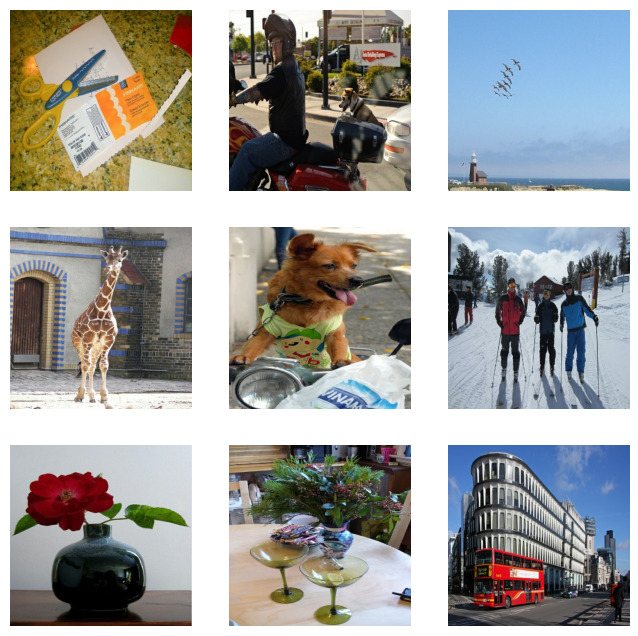

In [5]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(train_set[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

### 2.6 Création d'images bruitées

In [6]:
def apply_gaussian_noise(X, sigma=0.2):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    X += noise
    X[X>1] = 1.0
    X[X<0] = 0.0
    return X

x_train_noisy = apply_gaussian_noise(train_set.copy())
x_test_noisy = apply_gaussian_noise(test_set.copy())

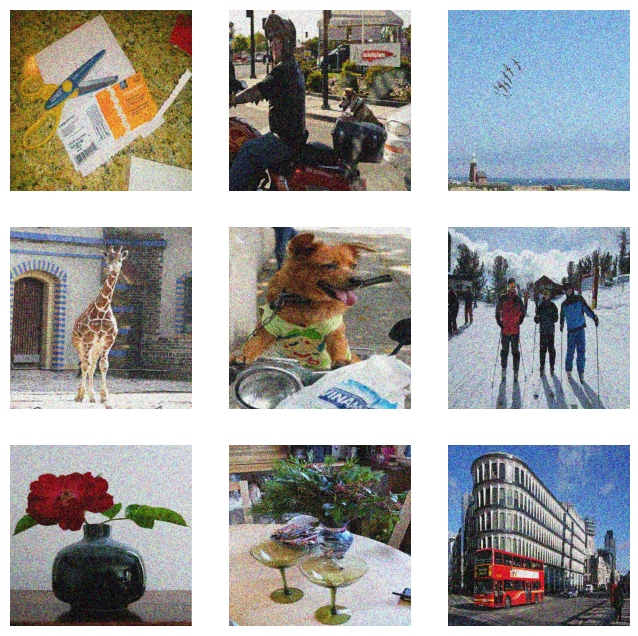

In [7]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(x_train_noisy[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

## III. Modélisation d'autoencodeurs pour le débruitage des images

### 3.1 Autoencodeur simple

##### 3.1.1 Définition du modèle

In [8]:
model_input = keras.Input(shape=(384, 384, 3))
x = layers.Flatten()(model_input)
x = layers.Dense(256, activation='relu')(x)
encoded = layers.Dense(64, activation='relu')(x)

x = layers.Dense(256, activation='relu')(encoded)
x = layers.Dense(442368, activation='relu')(x)
decoded = tf.keras.layers.Reshape(target_shape=(384,384,3))(x)

##### 3.1.2 Compilation du modèle

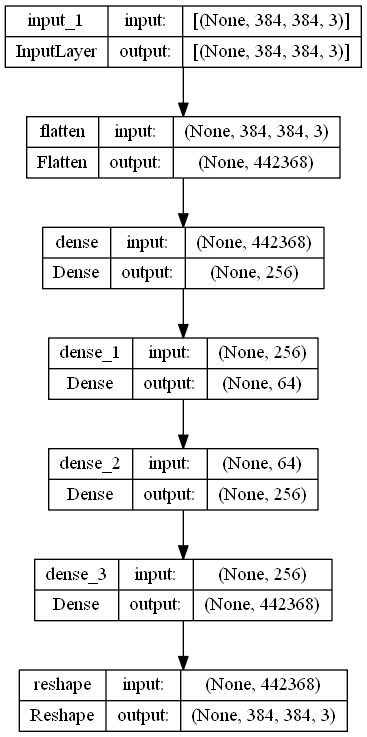

In [9]:
autoencoder = keras.Model(model_input, decoded)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
plot_model(autoencoder, show_shapes=True)

##### 3.1.3 Entrainement du modèle

In [10]:
epochs = 20
history = autoencoder.fit(
    x_train_noisy,train_set, batch_size=10, validation_data=(x_test_noisy,test_set), epochs=epochs, shuffle=True,
)

Epoch 1/20
12/12 [==============================] - 2s 80ms/step - loss: 1.2880 - mae: 0.6130 - val_loss: 0.2482 - val_mae: 0.4242
Epoch 2/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2596 - mae: 0.4256 - val_loss: 0.2358 - val_mae: 0.4096
Epoch 3/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2478 - mae: 0.4130 - val_loss: 0.2216 - val_mae: 0.3914
Epoch 4/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2436 - mae: 0.4080 - val_loss: 0.2203 - val_mae: 0.3904
Epoch 5/20
12/12 [==============================] - 1s 67ms/step - loss: 0.2525 - mae: 0.4181 - val_loss: 0.2240 - val_mae: 0.3956
Epoch 6/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2476 - mae: 0.4129 - val_loss: 0.2437 - val_mae: 0.4194
Epoch 7/20
12/12 [==============================] - 1s 66ms/step - loss: 0.2535 - mae: 0.4195 - val_loss: 0.2344 - val_mae: 0.4076
Epoch 8/20
12/12 [==============================] - 1s 68ms/step - loss: 0.2493 - m

##### 3.1.4 Entrainement du modèle

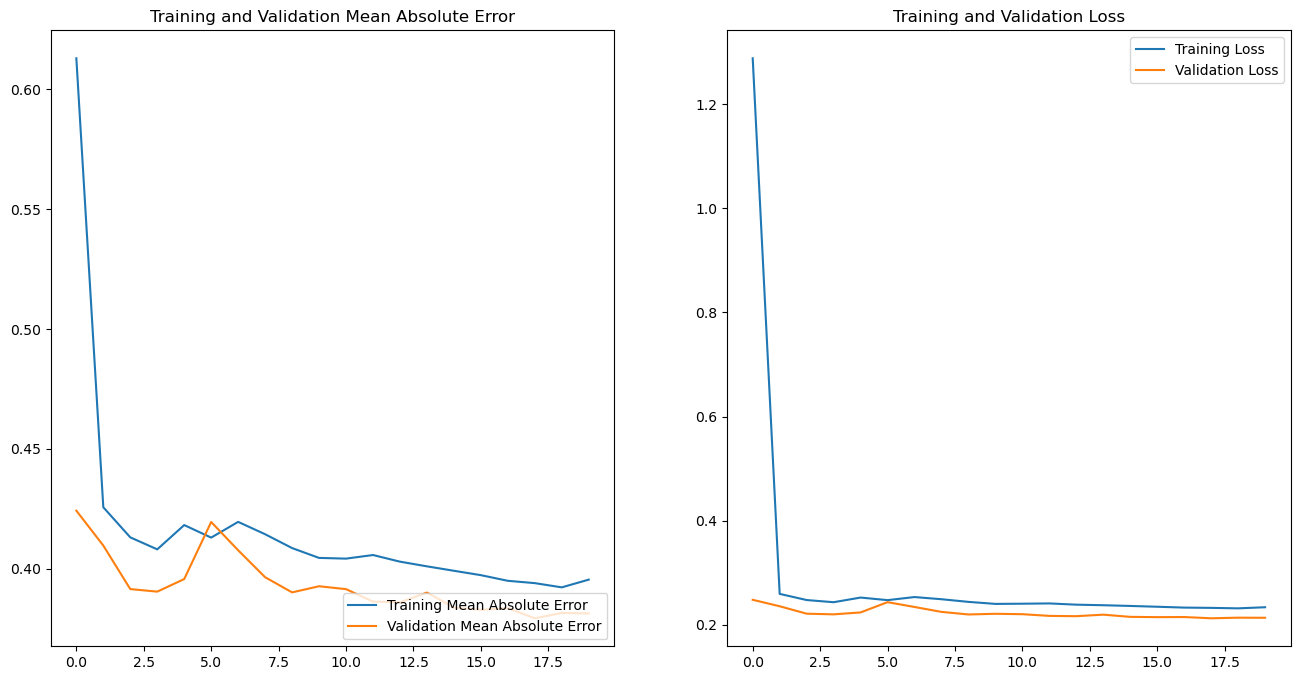

In [11]:
# Retrieve training and validation accuracy and loss history
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add first subplot showing training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Mean Absolute Error')
plt.plot(epochs_range, val_acc, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Mean Absolute Error')

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


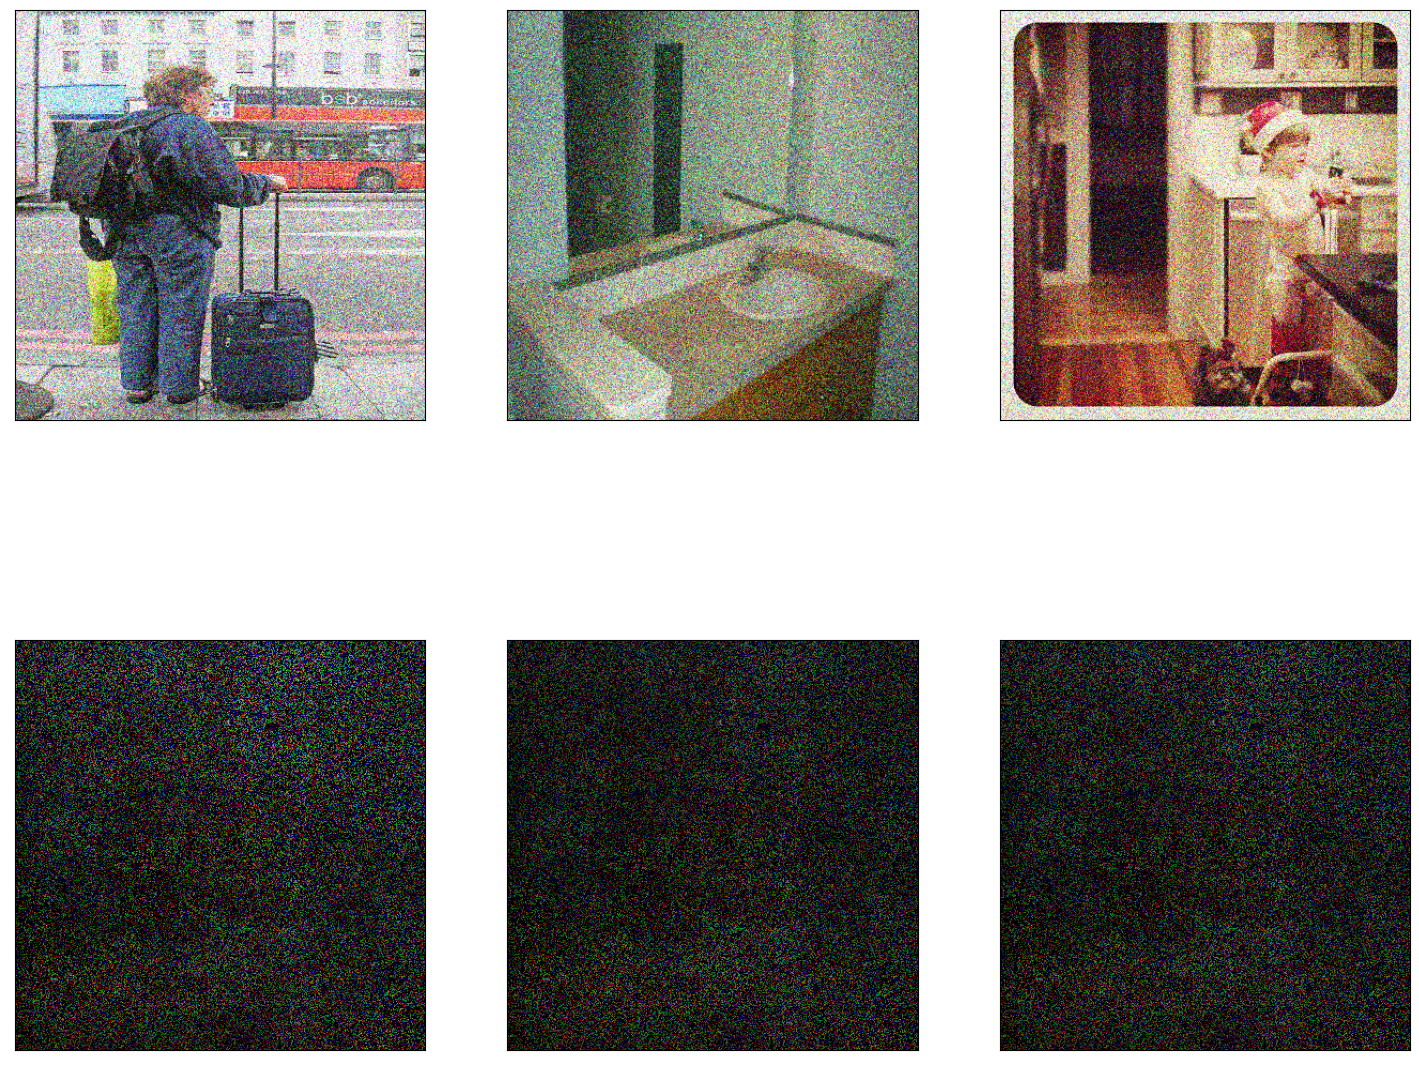

In [12]:
#x_test_noisy
#test_set

n = 3
plt.figure(figsize=(18, 15))

predictions = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### 3.2 Autoencodeur convolutif

##### 3.2.1 Définition du modèle

In [13]:
model_input = keras.Input(shape=(384, 384, 3))
x = layers.Conv2D(16, 3, activation='relu', padding='same')(model_input)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(256, 3, activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

##### 3.2.2 Compilation du modèle

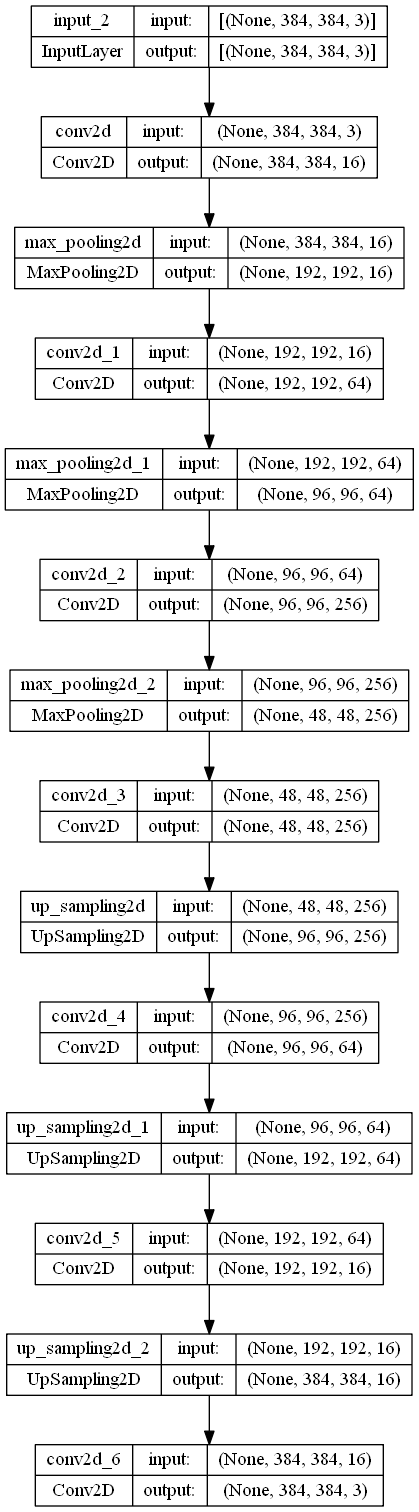

In [16]:
autoencoder = keras.Model(model_input, decoded)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
plot_model(autoencoder, show_shapes=True)

##### 3.2.3 Entraînement du modèle

In [17]:
# Exécution du modèle
epochs = 40
history = autoencoder.fit(
    x_train_noisy,train_set, batch_size=10, validation_data=(x_test_noisy,test_set), epochs=epochs, shuffle=True,
)

Epoch 1/20
12/12 [==============================] - 2s 126ms/step - loss: 0.0639 - mae: 0.1880 - val_loss: 0.0185 - val_mae: 0.1041
Epoch 2/20
12/12 [==============================] - 1s 106ms/step - loss: 0.0202 - mae: 0.1056 - val_loss: 0.0135 - val_mae: 0.0864
Epoch 3/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0148 - mae: 0.0882 - val_loss: 0.0092 - val_mae: 0.0673
Epoch 4/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0114 - mae: 0.0745 - val_loss: 0.0079 - val_mae: 0.0606
Epoch 5/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0100 - mae: 0.0678 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 6/20
12/12 [==============================] - 1s 106ms/step - loss: 0.0094 - mae: 0.0645 - val_loss: 0.0068 - val_mae: 0.0535
Epoch 7/20
12/12 [==============================] - 1s 105ms/step - loss: 0.0090 - mae: 0.0627 - val_loss: 0.0066 - val_mae: 0.0527
Epoch 8/20
12/12 [==============================] - 1s 106ms/step - loss: 0.

##### Résultat du modèle

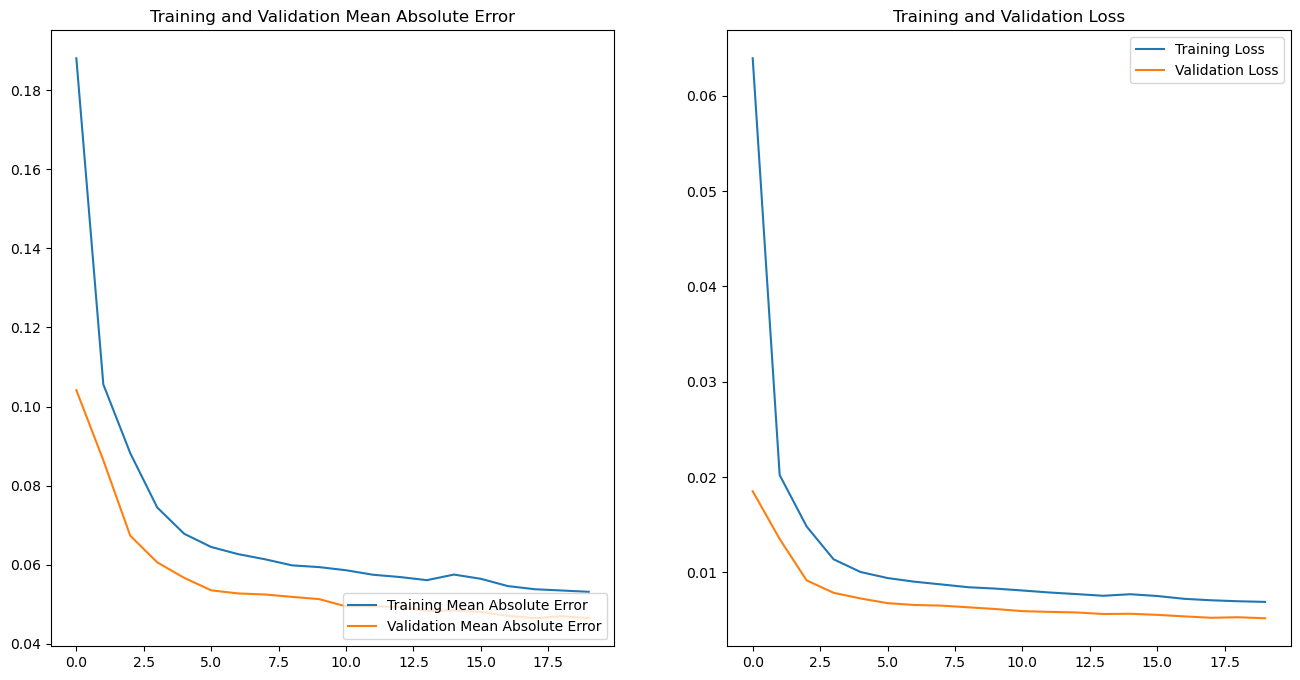

In [19]:
# Retrieve training and validation accuracy and loss history
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add first subplot showing training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Mean Absolute Error')
plt.plot(epochs_range, val_acc, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Mean Absolute Error')

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


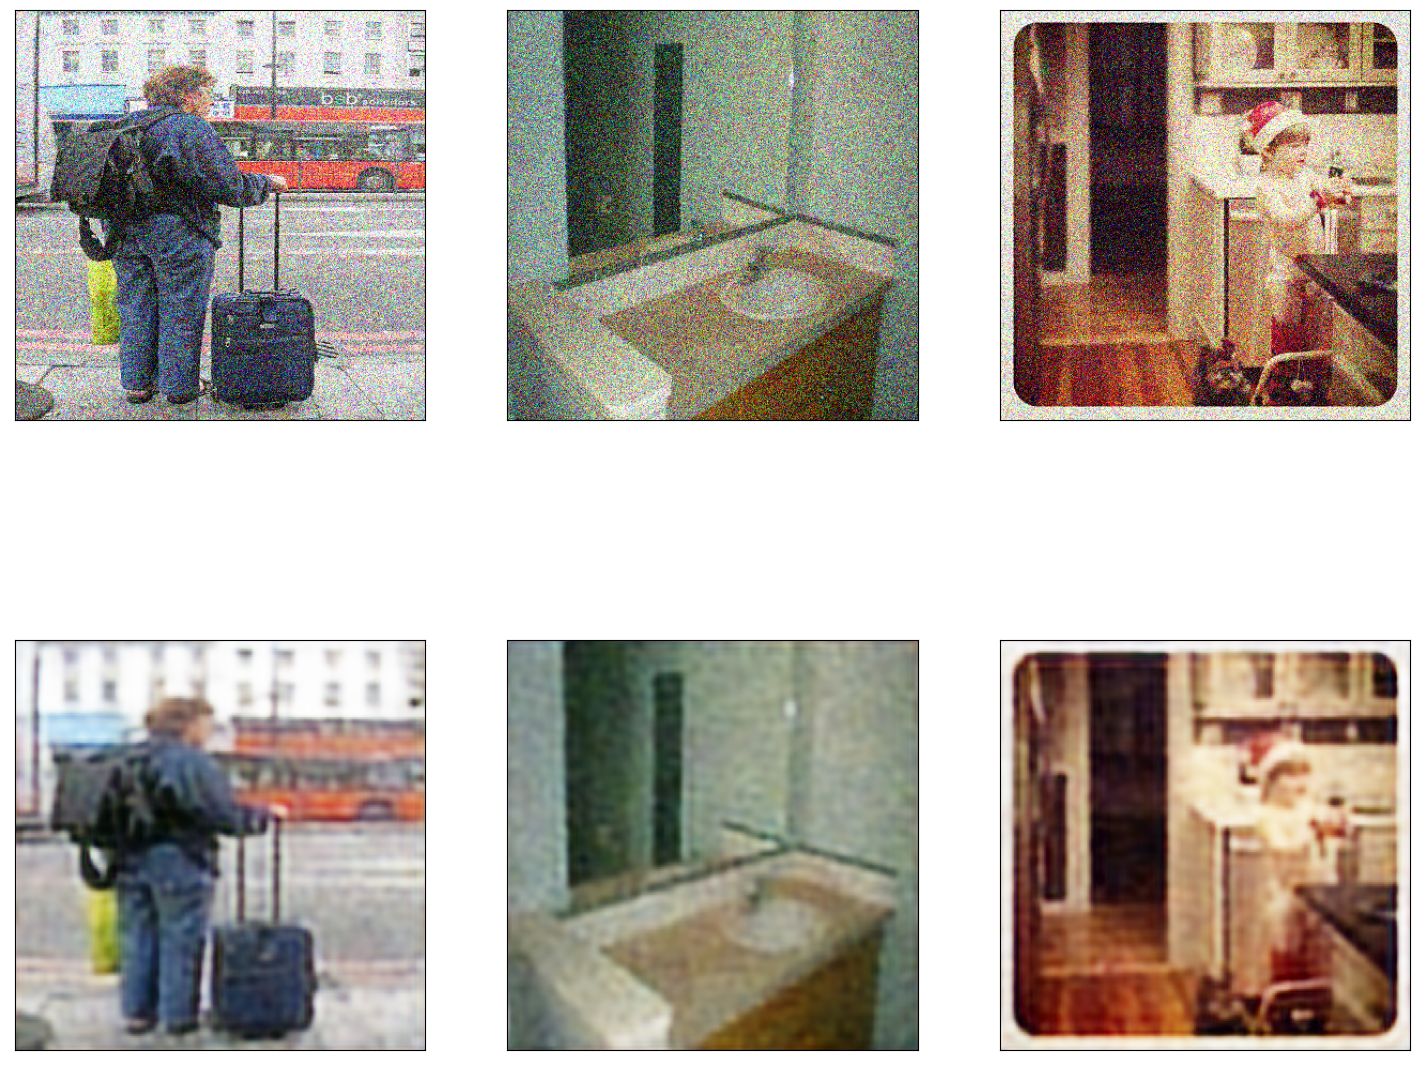

In [20]:
#x_test_noisy
#test_set

n = 3
plt.figure(figsize=(18, 15))

predictions = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### 3.2 VAE

## IV. Résultats et conclusion